# DiffEdit Implementation

In [1]:
# make sure your version of transformers and diffusers aligns with mine for the code to work
# pip install 'transformers==4.42.3' --force-reinstall
# pip install 'diffusers==0.29.2' --force-reinstall

In [2]:
from IPython.display import display
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
from fastdownload import FastDownload

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

### Personal Stable Diffusion Pipeline

This is my own stable diffusion pipeline class, built on huggingface models, and allowing me to experiment with different stable diffusion variants

In [22]:
class PersonalStableDiffusionPipeline:
    def __init__(self, tokenizer, text_encoder, vae, unet, scheduler, steps=70):
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.vae = vae
        self.unet = unet
        self.scheduler = scheduler
        self.steps = steps
        self.start_step = 0
        self.scheduler.set_timesteps(self.steps, device="cuda")
        
    def text_enc(self, prompts, maxlen=None):
        if maxlen is None: maxlen = tokenizer.model_max_length
        inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
        return text_encoder(inp.input_ids.to("cuda"))[0].half()
    
    def make_text_embeddings(self, prompts: list, negative_prompts: list=[]):
        text = self.text_enc(prompts)
        # handle negative prompts
        if negative_prompts: 
            if len(prompts) != len(negative_prompts): negative_prompts += [""] * (len(prompts)-len(negative_prompts))
            uncond = self.text_enc(negative_prompts)
        else: 
            uncond = self.text_enc([""] * len(prompts), text.shape[1])
        return torch.cat([uncond, text])
    
    def initialise_latents(self, num_to_init, init_img: torch.tensor=[], init_strength: float=0.5, img_height=512, img_width=512):
        latents = torch.randn((num_to_init, self.unet.config.in_channels, img_height//8, img_width//8))
        latents = latents * self.scheduler.init_noise_sigma
        # Adjust latents for image to image
        if len(init_img) > 0:
            # Adjust latent initialisation and # steps for image to image diffusion
            self.start_step = int(init_strength * self.steps)
            init_img = (init_img / 255.0).to("cuda").half()
            latents = 0.18215 * self.vae.encode(init_img*2-1).latent_dist.sample()
            noise = torch.randn_like(latents)
            latents = scheduler.add_noise(latents, noise, timesteps=torch.tensor([scheduler.timesteps[self.start_step]]))
            latents = torch.repeat_interleave(latents, num_to_init, 0)
            
        return latents.to("cuda").half()
    
    def run_denoising(self, emb, latents, callback=None, guidance_scale:float=7.5):
        if callback: images = []
        for step, ts in enumerate(tqdm(self.scheduler.timesteps)):
            if step >= self.start_step:
                inp = self.scheduler.scale_model_input(torch.cat([latents] * 2), ts)
                with torch.no_grad(): u,t = self.unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
                pred = u + guidance_scale*(t-u)
                latents = self.scheduler.step(pred, ts, latents).prev_sample
                if callback: images.append(latents)
        
        return images if callback else latents
    
    def forward(self, prompts: list, negative_prompts: list=[], init_img: torch.tensor=[], init_strength: float=0.5, callback=None, guidance_scale: float=7.5, seed: int=1, img_height: int=512, img_width: int=512):
        
        # Initialise number of prompts, seed, and scheduler
        bs = len(prompts)
        if seed: torch.manual_seed(seed)
        self.scheduler.set_timesteps(self.steps)
        # Create text embeddings and initial latents
        emb = self.make_text_embeddings(prompts, negative_prompts)
        latents = self.initialise_latents(bs, init_img, init_strength, img_height, img_width)
        latents = self.run_denoising(emb, latents, callback, guidance_scale)

        if callback: 
            with torch.no_grad(): return [vae.decode(1 / 0.18215 * i).sample for l in latents]
        else: 
            with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample
        
    

# DiffEdit Implementation

I'll use my personal pipeline as a base for implementing DiffEdit
* DiffEdit will build upon the image to image diffusion approach, for which the forward function will need to be overwritten.

In [41]:
class DiffEditPipeline(PersonalStableDiffusionPipeline):
    
    def make_text_embeddings(self, text: list=[]):
        # We don't deal with negative prompts in DiffEdit so this function is simpler
        uncond = self.text_enc([""], text.shape[1])
        emb = self.text_enc(text) if text else uncond
        return uncond, emb
    
    def make_mask(self, reference: list=[], query: list=[], init_img: torch.tensor=[], init_strength: float=0.5,
                  n_trials=10, guidance_scale: float=7.5, seed: int=1, img_height: int=512, img_width: int=512):
        assert init_img != [], "Provide an initial image for the init_img argument"
        assert query != [], "Provide a query text to edit the input image"
        print("Creating the mask...")
        # Initialise number of prompts, seed, and scheduler
        bs = len(prompts)
        if seed: torch.manual_seed(seed)
        self.scheduler.set_timesteps(self.steps)
        # We denoise once conditioned on the query, and once on the reference
        mask_differences = {}
        for i in range(n_trials):
            mask_difference = []
            for text in [query, reference]:
                # Create text embeddings and initial latents
                uncond, emb = self.make_text_embeddings(text)
                emb = torch.cat([uncond, emb])
                latents = self.initialise_latents(bs, init_img, init_strength, img_height, img_width)
                latents = self.run_denoising(emb, latents)

            mask_differences[i] = np.abs(mask_difference[0]-mask_difference[1])

        # computing the average of 10 trials
        mask = np.zeros_like(mask_differences[0])
        for i in range(n_trials):
            mask += mask_differences[i]
        mask.mean(0)
        # Normalising and Binarizing
        mask = (mask - mask.min) / (mask.max - mask.min)
        return (mask>0.5).astype("uint8") 
    
    def forward(self, reference: list=[], query: list=[], init_img: torch.tensor=[], init_strength: float=0.5,
                  n_trials=10, guidance_scale: float=7.5, seed: int=1, img_height: int=512, img_width: int=512):
        print("Editing the image")
        # initialise scheduler
        self.scheduler.set_timesteps(self.steps)
        # create the mask
        mask = self.make_mask(reference, query, init_img, init_strength, n_trials, guidance_scale, seed, img_height, img_width)
        mask = torch.tensor(mask, dtype=self.unet.dtype).unsqueeze(0).to("cuda")
        # get embeddings for the reference and query text
        uncond, ref_emb = self.make_text_embeddings(reference)
        _, query_emb = self.make_text_embeddings(query)
        emb = torch.cat([uncond, ref_emb, query_emb])
        # get latents
        # note that timesteps are adjusted inside our initialise_latents function
        latents = self.initialise_latents(len(prompts), init_img, init_strength, img_height, img_width)
        for i,ts in enumerate(tqdm(self.scheduler.timesteps)):
            if step >= self.start_step:
                inp = self.scheduler.scale_model_input(torch.cat([latents]*3), ts)
                with torch.no_grad(): u, rt, qt = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(3)
                # Performing Guidance
                rpred = u + g*(rt-u)
                qpred = u + g*(qt-u)
                # Conditioning  the latents
                rlatents = scheduler.step(rpred, ts, latents).prev_sample
                qlatents = scheduler.step(qpred, ts, latents).prev_sample
                latents = mask*qlatents + (1-mask)*rlatents
        
        with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

#### Auxilliary Functions

In [33]:
def plot_images_in_grid(images, grid_size=(10, 10), image_size=(20, 20)):
    num_images = len(images)
    num_rows = min(num_images // grid_size[0] + 1, grid_size[1])
    fig, axes = plt.subplots(num_rows, grid_size[0], figsize=(image_size[0],image_size[1]))

    for ax in axes.flatten():
        ax.axis('off')
        
    for i, image in enumerate(images):
        ax = axes[i // grid_size[0], i % grid_size[0]]
        if isinstance(image, torch.Tensor):
            image = image.cpu().detach().numpy()
        if len(image.shape) == 4: image = np.transpose(image.squeeze(), (1, 2, 0)) # Reshape if the image has shape (1, 3, 512, 512)
        else: image = np.transpose(image, (1,2,0))
        image = image.astype(np.float32)
        ax.imshow(image, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
def plot_image(image):
    if isinstance(image, torch.Tensor):
        image = image.cpu().detach().numpy()
    if len(image.shape) == 4: image = np.transpose(image.squeeze(), (1, 2, 0)) # Reshape if the image has shape (1, 3, 512, 512)
    else: image = np.transpose(image, (1,2,0))
    image = image.astype(np.float32)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

#### Setting pipeline components

In [23]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)
steps = 70

Initialising the pipeline

In [24]:
pipe = PersonalStableDiffusionPipeline(tokenizer, text_encoder, vae, unet, scheduler, steps)

### Example Usage

#### Simple stable diffusion from text prompt

In [25]:
prompts = [
 "an elephant in a bath of milk",   
]

In [26]:
images = pipe.forward(prompts)

  0%|          | 0/70 [00:00<?, ?it/s]

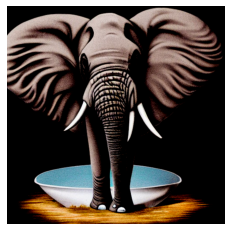

In [27]:
plot_image(images)

## DiffEdit Pipeline Example

In [42]:
edit_pipe = DiffEditPipeline(tokenizer, text_encoder, vae, unet, scheduler, steps)

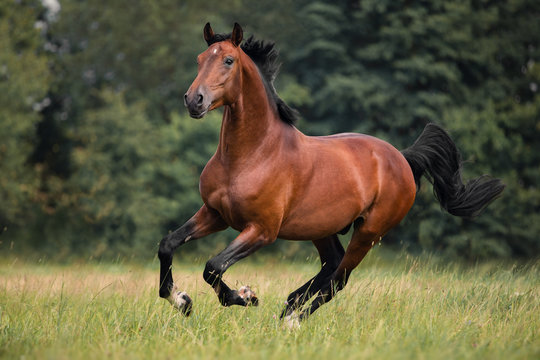

In [46]:
p = FastDownload().download("https://t3.ftcdn.net/jpg/03/26/50/04/360_F_326500445_ZD1zFSz2cMT1qOOjDy7C5xCD4shawQfM.jpg")
init_image = Image.open(p).convert("RGB")
init_image

In [47]:
init_image = torchvision.transforms.functional.pil_to_tensor(init_image)
init_image = init_image[None, :, :, :]

In [48]:
init_image.shape

torch.Size([1, 3, 360, 540])

In [51]:
ref_text = ""
query_text = "zebra"

In [52]:
images = pipe.forward([ref_text], [query_text], init_img=init_image, img_height=360, img_width=540)

  0%|          | 0/70 [00:00<?, ?it/s]

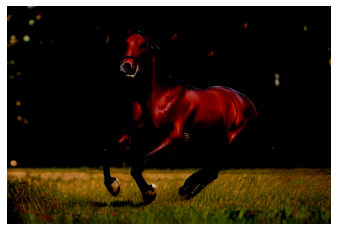

In [53]:
plot_image(images)